# Big Mart Sales

## Problem Statement

    Building a predictive model and find out the sales of each product at a particular store.
    The model will try to understand the properties of products and stores which play a key role in increasing sales.
    
## Hypothesis
    1. Different factors affect the selling of products.
    2. Products may sale more or less depending on the location and size of the store.
    3. Weight, visibility, pricing, establishment year and other variables affects sales
    
   


In [1]:
#loading packages
import pandas as pd
import numpy as np #for mathematical calculations
import seaborn as sns
import matplotlib.pyplot as plt #for plotting graphs
from datetime import datetime #to access datetime
from pandas import Series #to work on series
from pathlib import Path #to create path to directories and files
%matplotlib inline
import warnings #to ignore the warnings
warnings.filterwarnings('ignore')

In [2]:
#https://pbpython.com/notebook-process.html
today = datetime.today()
train = Path.cwd() /'data'/'raw'/'Train_File.csv'
test = Path.cwd() /'data'/'raw'/'Test_File.csv'
summary_file_train = Path.cwd() /'data'/'processed'/f'summary_train{today:%b-%d-%Y}.pkl'
summary_file_test = Path.cwd() /'data'/'processed'/f'summary_test{today:%b-%d-%Y}.pkl'

In [3]:
#reading train and test data
train = pd.read_csv(train)
test = pd.read_csv(test)

## Understanding the Data

In [4]:
train.head(5)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [5]:
train.shape, test.shape

((8523, 12), (5681, 11))

Train data has 12 variables both input and output variables, while the Test  dataset has only 11 variables excluding the output variable i.e. "Item_Outlet_Sales" which is to be predicted

In [6]:
train.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')

In [7]:
test.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type'],
      dtype='object')

In [8]:
train.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

#Numerical data summary:
data.describe()

### Combine Train and Test

    To explore data in any data science competition, it is advisable to append test data to the train data. Combining train and test sets saves a lot of time and effort because if we have to make any modification in the data, we would make the change only in the combined data and not in train and test data separately. Later we can always split the combined data back to train and test.

    For example, if we wish to multiply Item_Fat_Content variable by 100, we can do it for the train and test data separately or we can do the same operation once for the combined dataset. The latter approach is more efficient when there are a lot of changes to be made.

    So, we will go ahead combine both train and test data and will carry out data visualization, feature engineering, one-hot encoding, and label encoding. Later we would split this combined data back to train and test datasets.

In [9]:
#Combine test and train into one file
train['source']='train'
test['source']='test'
data = pd.concat([train, test],ignore_index=True)
print (train.shape, test.shape, data.shape)

(8523, 13) (5681, 12) (14204, 13)


## Univariate Analysis

    Let’s start with univariate EDA. It involves exploring variables individually. We will try to visualize the continuous variables using histograms and categorical variables using frequency tables.

### Target Variable

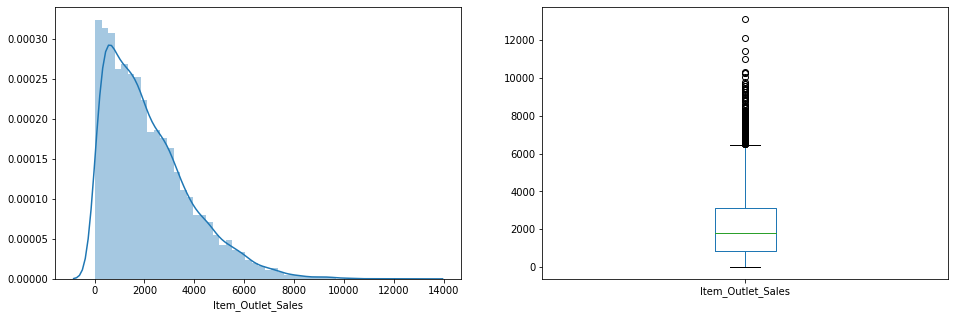

In [10]:
plt.figure(1)
plt.subplot(121)
sns.distplot(train['Item_Outlet_Sales'])
plt.subplot(122) 
train['Item_Outlet_Sales'].plot.box(figsize=(16,5)) 
plt.show()

    As you can see, it is a right skewd variable and would need some data transformation to treat its skewness.

### Independent Variables(Categorical)


Frequency of Categories for varible Item_Fat_Content
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64


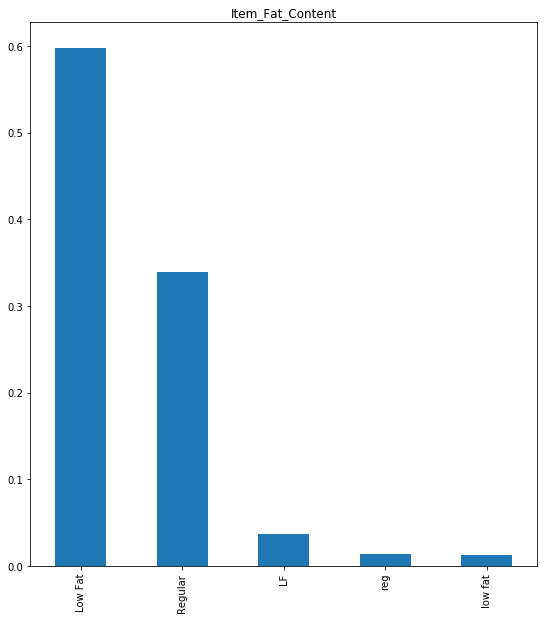


Frequency of Categories for varible Item_Type
Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64


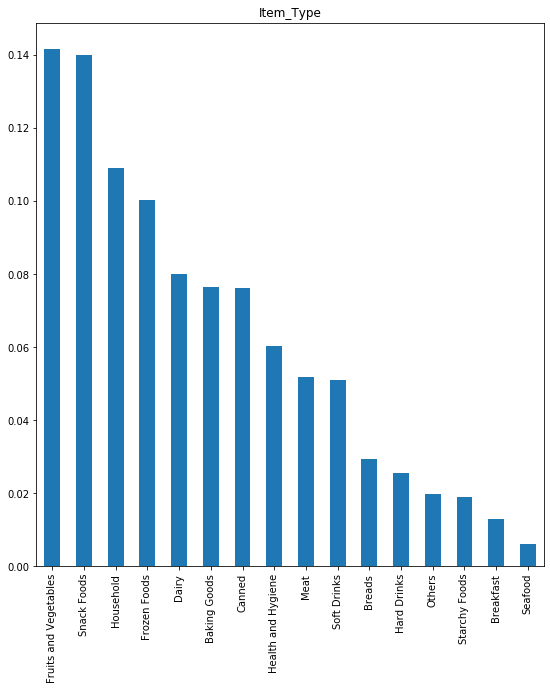


Frequency of Categories for varible Outlet_Location_Type
Tier 3    5583
Tier 2    4641
Tier 1    3980
Name: Outlet_Location_Type, dtype: int64


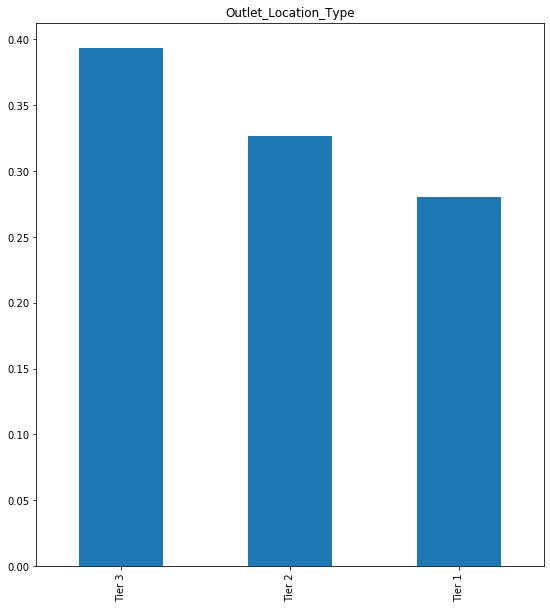


Frequency of Categories for varible Outlet_Size
Medium    4655
Small     3980
High      1553
Name: Outlet_Size, dtype: int64


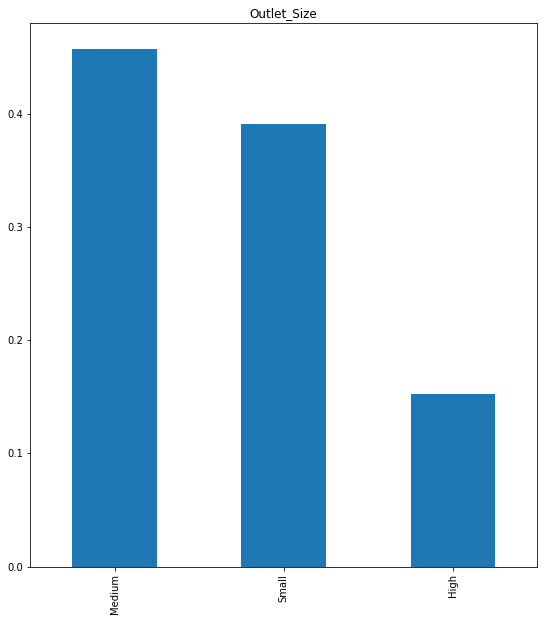


Frequency of Categories for varible Outlet_Type
Supermarket Type1    9294
Grocery Store        1805
Supermarket Type3    1559
Supermarket Type2    1546
Name: Outlet_Type, dtype: int64


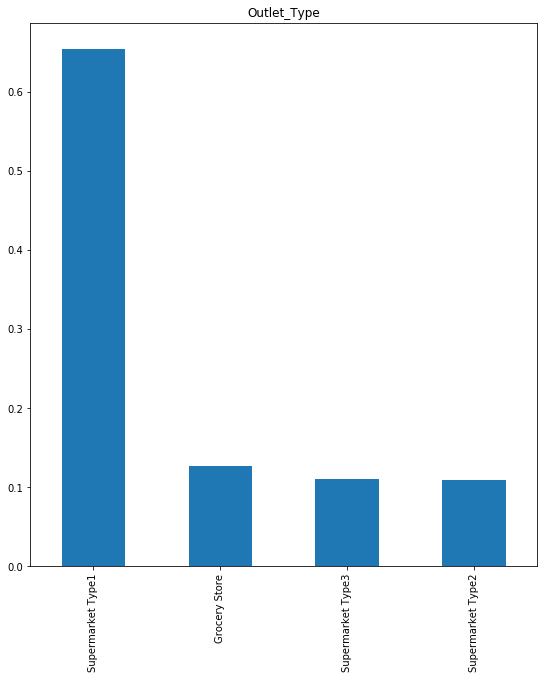

In [11]:
#Filter categorical variables
categorical_columns = [x for x in data.dtypes.index if data.dtypes[x]=='object']
#Exclude ID cols and source:
categorical_columns = [x for x in categorical_columns if x not in ['Item_Identifier','Outlet_Identifier','source']]
for col in categorical_columns:
    #Print frequency of categories
    print ('\nFrequency of Categories for varible %s'%col)
    print (data[col].value_counts())
    #disply bar plots
    n = 121
    plt.figure(1)
    plt.subplot(n)
    data[col].value_counts(normalize=True).plot.bar(figsize=(20,10), title= col)
    n += 1
    plt.show()

    From above, ‘LF’, ‘low fat’, and ‘Low Fat’ are the same category and can be combined into one. Similarly we can be done for ‘reg’ and ‘Regular’ into one.
    In Outlet_Size’s plot, for 4016 observations, Outlet_Size is blank or missing.We will check for this in the bivariate analysis to substitute the missing values in the Outlet_Size.
    Lesser number of observations in the data for the outlets established in the year 1998 as compared to the other years.
    Supermarket Type 1 seems to be the most popular category of Outlet_Type.

#### Modifying Category Item_Fat_Content

In [12]:
#Change categories of low fat:
print ('Original Categories:')
print (data['Item_Fat_Content'].value_counts())

print ('\nModified Categories:')
data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({'LF':'Low Fat',
                                                             'reg':'Regular',
                                                             'low fat':'Low Fat'})
print (data['Item_Fat_Content'].value_counts())

Original Categories:
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Modified Categories:
Low Fat    9185
Regular    5019
Name: Item_Fat_Content, dtype: int64


### Independent Variable(Numerical)

In [13]:
#checking for missing values
data.isnull().sum()

Item_Fat_Content                0
Item_Identifier                 0
Item_MRP                        0
Item_Outlet_Sales            5681
Item_Type                       0
Item_Visibility                 0
Item_Weight                  2439
Outlet_Establishment_Year       0
Outlet_Identifier               0
Outlet_Location_Type            0
Outlet_Size                  4016
Outlet_Type                     0
source                          0
dtype: int64

#### Imputation

In [14]:
#Determine the average weight per item:
item_avg_weight = data.pivot_table(values='Item_Weight', index='Item_Identifier')

#Get a boolean variable specifying missing Item_Weight values
miss_bool = data['Item_Weight'].isnull() 

#Impute data and check #missing values before and after imputation to confirm
print ('Orignal #missing: %d'% sum(miss_bool))
#data.loc[miss_bool,'Item_Weight'] = data.loc[miss_bool,'Item_Identifier'].apply(lambda x: item_avg_weight[x])
data.loc[miss_bool,'Item_Weight'] = data.loc[miss_bool,'Item_Identifier'].apply(lambda x: item_avg_weight.at[x,'Item_Weight'])
print ('Final #missing: %d'% sum(data['Item_Weight'].isnull()))

Orignal #missing: 2439
Final #missing: 0


In [15]:
#Import mode function:
from scipy.stats import mode

#Determing the mode for each
outlet_size_mode = data.pivot_table(values='Outlet_Size', columns='Outlet_Type',aggfunc=(lambda x:mode(x).mode[0]) )
print ('Mode for each Outlet_Type:')
print (outlet_size_mode)

#Get a boolean variable specifying missing Item_Weight values
miss_bool = data['Outlet_Size'].isnull() 

#Impute data and check #missing values before and after imputation to confirm
print ('\nOrignal #missing: %d'% sum(miss_bool))
data.loc[miss_bool,'Outlet_Size'] = data.loc[miss_bool,'Outlet_Type'].apply(lambda x: outlet_size_mode[x])
print (sum(data['Outlet_Size'].isnull()))

Mode for each Outlet_Type:
Outlet_Type Grocery Store Supermarket Type1 Supermarket Type2  \
Outlet_Size         Small             Small            Medium   

Outlet_Type Supermarket Type3  
Outlet_Size            Medium  

Orignal #missing: 4016
0


    Missing data in Item_Outlet_Sales can be ignored since they belong to the test dataset. 

In [16]:
data.tail(30)

,Item_Fat_Content,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Type,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Identifier,Outlet_Location_Type,Outlet_Size,Outlet_Type,source
14174,Regular,FDD23,186.1898,NaN,Starchy Foods,0.048645,9.500,1987,OUT013,Tier 3,High,Supermarket Type1,test
14175,Low Fat,FDP32,126.7678,NaN,Fruits and Vegetables,0.087847,6.650,2002,OUT045,Tier 2,Small,Supermarket Type1,test
14176,Regular,FDO31,80.2960,NaN,Fruits and Vegetables,0.028977,6.760,2004,OUT035,Tier 2,Small,Supermarket Type1,test
14177,Low Fat,FDQ57,144.5760,NaN,Snack Foods,0.000000,7.275,1987,OUT013,Tier 3,High,Supermarket Type1,test
14178,Regular,FDX32,143.6786,NaN,Fruits and Vegetables,0.099375,15.100,1985,OUT027,Tier 3,Medium,Supermarket Type3,test
14179,Low Fat,FDC39,207.8296,NaN,Dairy,0.158425,7.405,1985,OUT027,Tier 3,Medium,Supermarket Type3,test
14180,Low Fat,FDU55,261.3278,NaN,Fruits and Vegetables,0.035911,16.200,1997,OUT046,Tier 1,Small,Supermarket Type1,test
14181,Low Fat,FDL45,123.4704,NaN,Snack Foods,0.037656,15.600,1987,OUT013,Tier 3,High,Supermarket Type1,test
14182,Low Fat,DRK37,188.8530,NaN,Soft Drinks,0.044073,5.000,1999,OUT049,Tier 1,Medium,Supermarket Type1,test
14183,Low Fat,FDK22,215.3850,NaN,Snack Foods,0.026065,9.800,1987,OUT013,Tier 3,High,Supermarket Type1,test


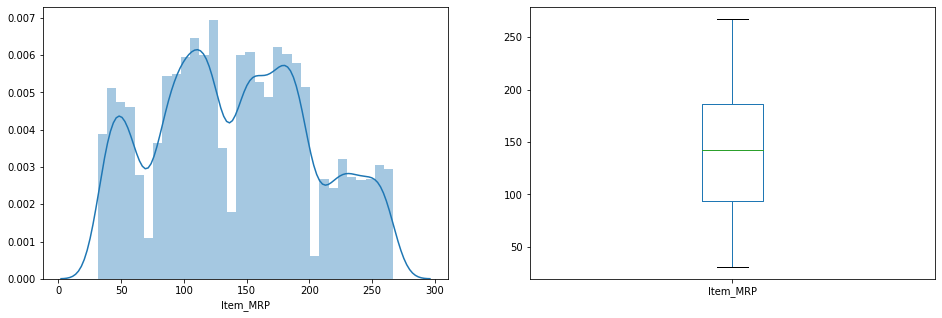

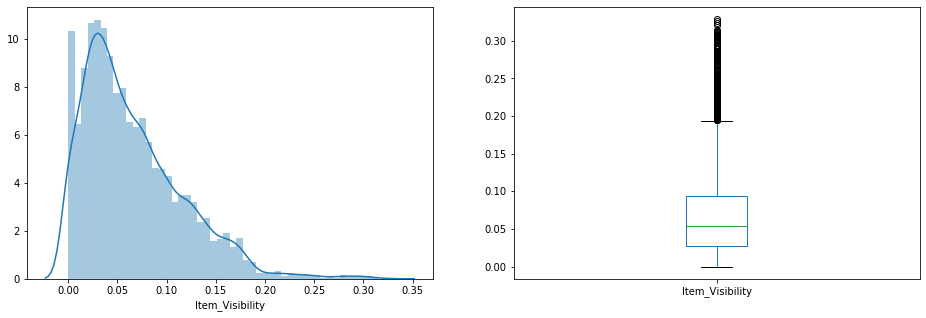

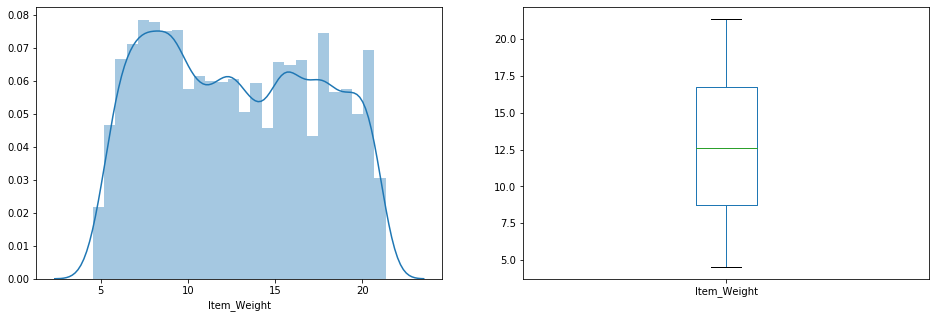

In [17]:
#Filter numerical variables
numerical_columns = [x for x in data.dtypes.index if data.dtypes[x]=='float64']
#Exclude Item_Outlet_Sales since it contains NaN values which are not intergers
numerical_columns = [x for x in numerical_columns if x not in ['Item_Outlet_Sales']]

for col in numerical_columns:
    plt.figure(1) 
    plt.subplot(121)
    sns.distplot(data[col])
    plt.subplot(122) 
    data[col].plot.box(figsize=(16,5)) 
    plt.show()

#### Observations

- There seems to be no clear-cut pattern in Item_Weight.
- Item_Visibility is right-skewed and should be transformed to curb its skewness.
- We can clearly see 4 different distributions for Item_MRP. It is an interesting insight.

## Bivariate Analysis

    After looking at every feature individually, let’s now do some bivariate analysis. Here we’ll explore the independent variables with respect to the target variable. The objective is to discover hidden relationships between the independent variable and the target variable and use those findings in missing data imputation and feature engineering in the next module.

    We will make use of scatter plots for the continuous or numeric variables and violin plots for the categorical variables.

### Target Variable vs Independent Numerical Variables

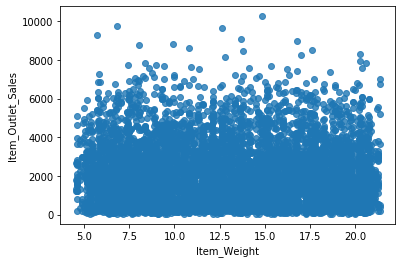

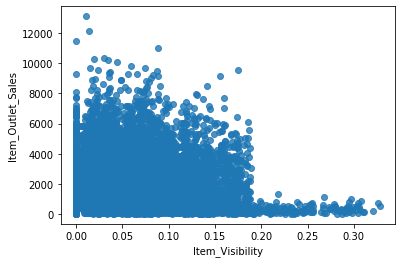

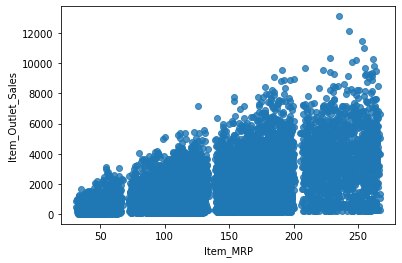

"\nplt.figure(1) \nsns.regplot(x=train['Item_MRP'],y=target,fit_reg=False)\nplt.figure(2)\nsns.regplot(x=train['Item_Visibility'],y=target,fit_reg=False)\nplt.figure(3)\nsns.regplot(x=train['Item_Weight'],y=target,fit_reg=False)\nplt.show()\n"

In [18]:
#Filter numerical variables
numerical_columns = [x for x in train.dtypes.index if train.dtypes[x]=='float64']
#Exclude Item_Outlet_Sales since it contains NaN values which are not intergers
numerical_columns = [x for x in numerical_columns if x not in ['Item_Outlet_Sales']]
target = train["Item_Outlet_Sales"]
n = 0
for col in numerical_columns:
    plt.figure(n)
    sns.regplot(x=train[col],y=target,fit_reg=False)
    plt.show()
    n += 1
    
    
'''
plt.figure(1) 
sns.regplot(x=train['Item_MRP'],y=target,fit_reg=False)
plt.figure(2)
sns.regplot(x=train['Item_Visibility'],y=target,fit_reg=False)
plt.figure(3)
sns.regplot(x=train['Item_Weight'],y=target,fit_reg=False)
plt.show()
'''

#### Observations

- Item_Outlet_Sales is spread well across the entire range of the Item_Weight without any obvious pattern.

- In Item_Visibility vs Item_Outlet_Sales, there is a string of points at Item_Visibility = 0.0 which seems strange as item visibility cannot be completely zero. We will take note of this issue and deal with it in the later stages.

- In the third plot of Item_MRP vs Item_Outlet_Sales, we can clearly see 4 segments of prices that can be used in feature engineering to create a new variable.

### Target Variable vs Independent Catergorical Variables

    Now we’ll visualise the categorical variables with respect to Item_Outlet_Sales. We will try to check the distribution of the target variable across all the categories of each of the categorical variable.

    We could have used boxplots here, but instead we’ll use the violin plots as they show the full distribution of the data. The width of a violin plot at a particular level indicates the concentration or density of data at that level. The height of a violin tells us about the range of the target variable values.

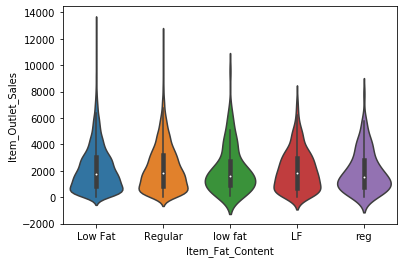

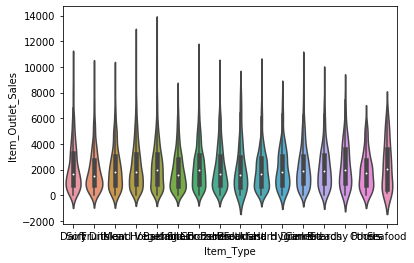

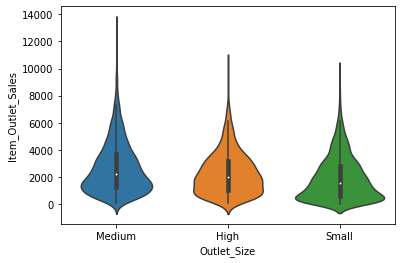

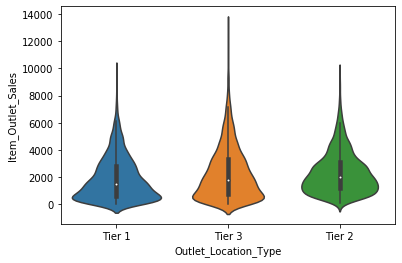

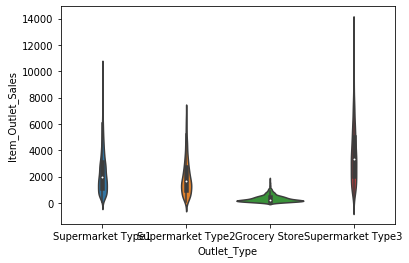

In [19]:
#Filter categorical variables
categorical_columns = [x for x in train.dtypes.index if train.dtypes[x]=='object']
#Exclude ID cols and source:
categorical_columns = [x for x in categorical_columns if x not in ['Item_Identifier','Outlet_Identifier','source']]
n = 0
for col in categorical_columns:
    plt.figure(n)
    sns.violinplot(x=train[col],y=train['Item_Outlet_Sales'])
    plt.show()
    n += 1

#### Observations

- Distribution of Item_Outlet_Sales across the categories of Item_Type is not very distinct and same is the case with Item_Fat_Content.

- The distribution for OUT010 and OUT019 categories of Outlet_Identifier are quite similar and very much different from the rest of the categories of Outlet_Identifier.

        In the univariate analysis, we came to know about the empty values in Outlet_Size variable. Let’s check the distribution of the target variable across Outlet_Size.
        
        The distribution of ‘Small’ Outlet_Size is almost identical to the distribution of the blank category (first vioin) of Outlet_Size. So, we can substitute the blanks in Outlet_Size with ‘Small’.

        Please note that this is not the only way to impute missing values, but for the time being we will go ahead and impute the missing values with ‘Small’.
        
        
- Tier 1 and Tier 3 locations of Outlet_Location_Type look similar.

- In the Outlet_Type plot, Grocery Store has most of its data points around the lower sales values as compared to the other categories.


        These are the kind of insights that we can extract by visualizing our data. Hence, data visualization should be an important part of any kind data analysis.

## Feature Engineering

    Most of the times, the given features in a dataset are not sufficient to give satisfactory predictions. In such cases, we have to create new features which might help in improving the model’s performance. Let’s try to create some new features for our dataset.

    In this section we will create the following new features:

- Item_Type_new: Broader categories for the variable Item_Type.
- Item_category: Categorical variable derived from Item_Identifier.
- Outlet_Years: Years of operation for outlets.
- price_per_unit_wt: Item_MRP/Item_Weight
- Item_MRP_clusters: Binned feature for Item_MRP.

    We can have a look at the Item_Type variable and classify the categories into perishable and non_perishable as per our understanding and make it into a new feature.

    Let’s compare Item_Type with the first 2 characters of Item_Identifier, i.e., ‘DR’, ‘FD’, and ‘NC’. These identifiers most probably stand for drinks, food, and non-consumable.

### Broad Category of Type of Item

In [20]:
#Item type combine:
data['Item_Identifier'].value_counts()
data['Item_Type_Combined'] = data['Item_Identifier'].apply(lambda x: x[0:2])
data['Item_Type_Combined'] = data['Item_Type_Combined'].map({'FD' : 'Food', 'NC':'Non-Consumable', 'DR':'Drinks'})
data['Item_Type_Combined'].value_counts()

Food              10201
Non-Consumable     2686
Drinks             1317
Name: Item_Type_Combined, dtype: int64

### Modifying Categories of Item_Fat_Content

    We have to change the values of Item_Fat_Content wherever Item_category is ‘NC’ because non-consumable items cannot have any fat content. We will also create a couple of more features — Outlet_Years (years of operation) and price_per_unit_wt (price per unit weight).

In [21]:
#mark non-consumable as seperate category in low_fat
data.loc[data['Item_Type_Combined']=='Non-Consumable','Item_Fat_Content'] = "Non-Edible"
data['Item_Fat_Content'].value_counts()

Low Fat       6499
Regular       5019
Non-Edible    2686
Name: Item_Fat_Content, dtype: int64

### Determine the Years of Operation of a Store

In [22]:
#years
data['Outlet_Years'] = 2013 - data['Outlet_Establishment_Year']
data['Outlet_Years'].describe()

count    14204.000000
mean        15.169319
std          8.371664
min          4.000000
25%          9.000000
50%         14.000000
75%         26.000000
max         28.000000
Name: Outlet_Years, dtype: float64

### Modify Item_Visibility

In [23]:
#Determine average visibility of a product
visibility_avg = data.pivot_table(values='Item_Visibility', index='Item_Identifier')

#Impute 0 values with mean visibility of that product:
miss_bool = (data['Item_Visibility'] == 0)

print ('Number of 0 values initially: %d'%sum(miss_bool))
data.loc[miss_bool,'Item_Visibility'] = data.loc[miss_bool,'Item_Identifier'].apply(lambda x: visibility_avg.at[x, 'Item_Visibility'])
print ('Number of 0 values after modification: %d'%sum(data['Item_Visibility'] == 0))

Number of 0 values initially: 879
Number of 0 values after modification: 0


In [24]:
#Determine another variable with means ratio
data['Item_Visibility_MeanRatio'] = data.apply(lambda x: x['Item_Visibility']/visibility_avg.at[x['Item_Identifier'],'Item_Visibility'], axis=1)
print (data['Item_Visibility_MeanRatio'].describe())

count    14204.000000
mean         1.061884
std          0.235907
min          0.844563
25%          0.925131
50%          0.999070
75%          1.042007
max          3.010094
Name: Item_Visibility_MeanRatio, dtype: float64


    Earlier in the Item_MRP vs Item_Outlet_Sales plot, we saw Item_MRP was spread across in 4 chunks. Now let’s assign a label to each of these chunks and use this label as a new variable.

### Combining Categories in Outlet_Type

In [25]:
#check the mean sales by type:
data.pivot_table(values='Item_Outlet_Sales', index='Outlet_Type')

,Item_Outlet_Sales
Outlet_Type,
Grocery Store,339.828500
Supermarket Type1,2316.181148
Supermarket Type2,1995.498739
Supermarket Type3,3694.038558


## Encoding Categorical Variables

    Why encoding categorical variables is essential?
    
    
    Most of the machine learning algorithms produce better result with numerical variables only. So, it is essential to treat the categorical variables present in the data. One thing that can be done is to completely remove the categorical variables, but that would lead to enormous loss of information. Fortunately we have smarter techniques to deal with the categorical variables.

    In this stage, we will convert our categorical variables into numerical ones. We will use 2 techniques — Label Encoding and One Hot Encoding.

1. Label encoding simply means converting each category in a variable to a number. It is more suitable for ordinal variables — categorical variables with some order.

2. In One hot encoding, each category of a categorical variable is converted into a new binary column (1/0).

In [26]:
#import library:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
#New variable for outlet
data['Outlet'] = le.fit_transform(data['Outlet_Identifier'])
var_mod = ['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Item_Type_Combined','Outlet_Type','Outlet']
le = LabelEncoder()
for i in var_mod:
    data[i] = le.fit_transform(data[i])

In [27]:
#One Hot Coding:
data = pd.get_dummies(data, columns=['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Item_Type_Combined','Outlet_Type','Outlet'])

In [28]:
data.dtypes

Item_Identifier               object
Item_MRP                     float64
Item_Outlet_Sales            float64
Item_Type                     object
Item_Visibility              float64
Item_Weight                  float64
Outlet_Establishment_Year      int64
Outlet_Identifier             object
source                        object
Outlet_Years                   int64
Item_Visibility_MeanRatio    float64
Item_Fat_Content_0             uint8
Item_Fat_Content_1             uint8
Item_Fat_Content_2             uint8
Outlet_Location_Type_0         uint8
Outlet_Location_Type_1         uint8
Outlet_Location_Type_2         uint8
Outlet_Size_0                  uint8
Outlet_Size_1                  uint8
Outlet_Size_2                  uint8
Item_Type_Combined_0           uint8
Item_Type_Combined_1           uint8
Item_Type_Combined_2           uint8
Outlet_Type_0                  uint8
Outlet_Type_1                  uint8
Outlet_Type_2                  uint8
Outlet_Type_3                  uint8
O

In [29]:
data[['Item_Fat_Content_0','Item_Fat_Content_1','Item_Fat_Content_2']].head(10)

,Item_Fat_Content_0,Item_Fat_Content_1,Item_Fat_Content_2
0,1,0,0
1,0,0,1
2,1,0,0
3,0,0,1
4,0,1,0
5,0,0,1
6,0,0,1
7,1,0,0
8,0,0,1
9,0,0,1


## Exporting Data

In [30]:
#dropping columns channged to different types:
data.drop(['Item_Type','Outlet_Establishment_Year'], axis=1, inplace=True)

#seperate into test and train:
train = data.loc[data['source']=='train']
test = data.loc[data['source']=='test']

#drop unnecessary columns:
test.drop(['Item_Outlet_Sales','source'],axis=1,inplace=True)
train.drop(['source'], axis=1,inplace=True)

In [31]:
#saving output file into processed directory
train.to_pickle(summary_file_train)
test.to_pickle(summary_file_test)